# **Named Entity Recognition (NER) with LSTMs**

## **Project Overview**

This project involves training a Long Short-Term Memory (LSTM) network for **Named Entity Recognition (NER)**. NER identifies entities such as names, organizations, and locations in text.

## **Dataset**

- **File**: `ner_dataset.csv`
- **Description**: Contains sentences with words, parts of speech (POS), and entity tags.
- **Rows**: 69,406
- **Columns**: Sentence Number, Word, POS, Tag

## **Objective**

- **Goal**: Train an LSTM model to accurately classify named entities in text.
- **Steps**: 
  1. **Preprocess** data (handle missing values, encode text).
  2. **Transform** data (create mappings for words and tags).
  3. **Train** the LSTM model and evaluate its performance.

## **Expected Outcome**

Enhance NER accuracy using LSTM networks to better identify and classify entities in text data.


#### **Load Modeules**

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf

#### **Load and Explore the NER Dataset**

In [64]:
data = pd.read_csv("ner_dataset.csv", encoding='utf-8', encoding_errors='replace')

In [65]:
#Looking for null values
print(data.isnull().sum())

Sentence #    69406
Word              0
POS               0
Tag               0
dtype: int64


In [66]:
data = data.ffill()
data.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [67]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 9216
Unique Tag in corpus: 17


In [68]:
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [69]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [70]:
num_words, num_tags

(9217, 17)

#### **Retrieve Sentences and Corresponsing Tags**

In [71]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, message="DataFrameGroupBy.apply operated on the grouping columns")

In [72]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentances = [s for s in self.grouped]

In [73]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [74]:
sentances[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

#### **Define Mappings between Sentences and Tags**

In [75]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [76]:
word2idx

{'Nepal': 1,
 'rafts': 2,
 'characterized': 3,
 'shown': 4,
 'renew': 5,
 'Kuwait': 6,
 'conform': 7,
 'committing': 8,
 'Fire': 9,
 'experiencing': 10,
 'close': 11,
 'indissoluble': 12,
 'lifting': 13,
 'Lopez-Alegria': 14,
 'removes': 15,
 'statehood': 16,
 'very': 17,
 'Thanksgiving': 18,
 'Adawe': 19,
 '2010': 20,
 'collectors': 21,
 'ocean': 22,
 'geese': 23,
 'diarrhea': 24,
 'Qureia': 25,
 'Ayman': 26,
 'Aktham': 27,
 'statements': 28,
 'conducted': 29,
 'in': 30,
 'foes': 31,
 'tasked': 32,
 'Philippine': 33,
 'objections': 34,
 'gross': 35,
 'jets': 36,
 'beating': 37,
 'vault': 38,
 'Phnom': 39,
 'Committee': 40,
 'consumer': 41,
 'Leonella': 42,
 'mortgage': 43,
 'Awami': 44,
 'OAS': 45,
 'extremists': 46,
 'lakeside': 47,
 'Lebar': 48,
 'financial': 49,
 'cancel': 50,
 'memorandum': 51,
 ',': 52,
 'February': 53,
 'startup': 54,
 'resold': 55,
 "'": 56,
 'attract': 57,
 'ten': 58,
 'criticized': 59,
 'by-election': 60,
 'harmonious': 61,
 'Susan': 62,
 'body': 63,
 'Lion':

#### **Padding Input Sentences and Creating Train/Test Splits**

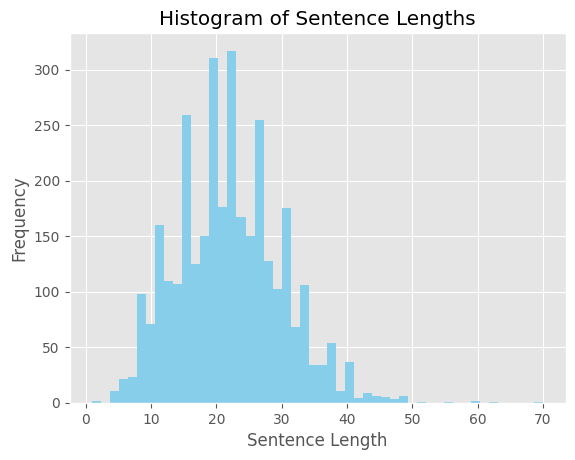

In [77]:
import matplotlib.pyplot as plt

# Plot histogram with custom color
plt.hist([len(s) for s in sentances], bins=50, color='skyblue')  # Change 'skyblue' to your preferred color
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sentence Lengths')
plt.show()


In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [49]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=1)

#### **Build and Compile a Bidirectional LSTM Model**

In [78]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [79]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Argument `input_length` is deprecated. Just remove it.")

input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 50, 50)              │         460,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 50, 50)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 50, 200)             │         120,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 50, 17)              │           3,417 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 585,067 (2.23 MB)

 Trainable params: 585,067 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

#### **Train the Model**

In [80]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [81]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

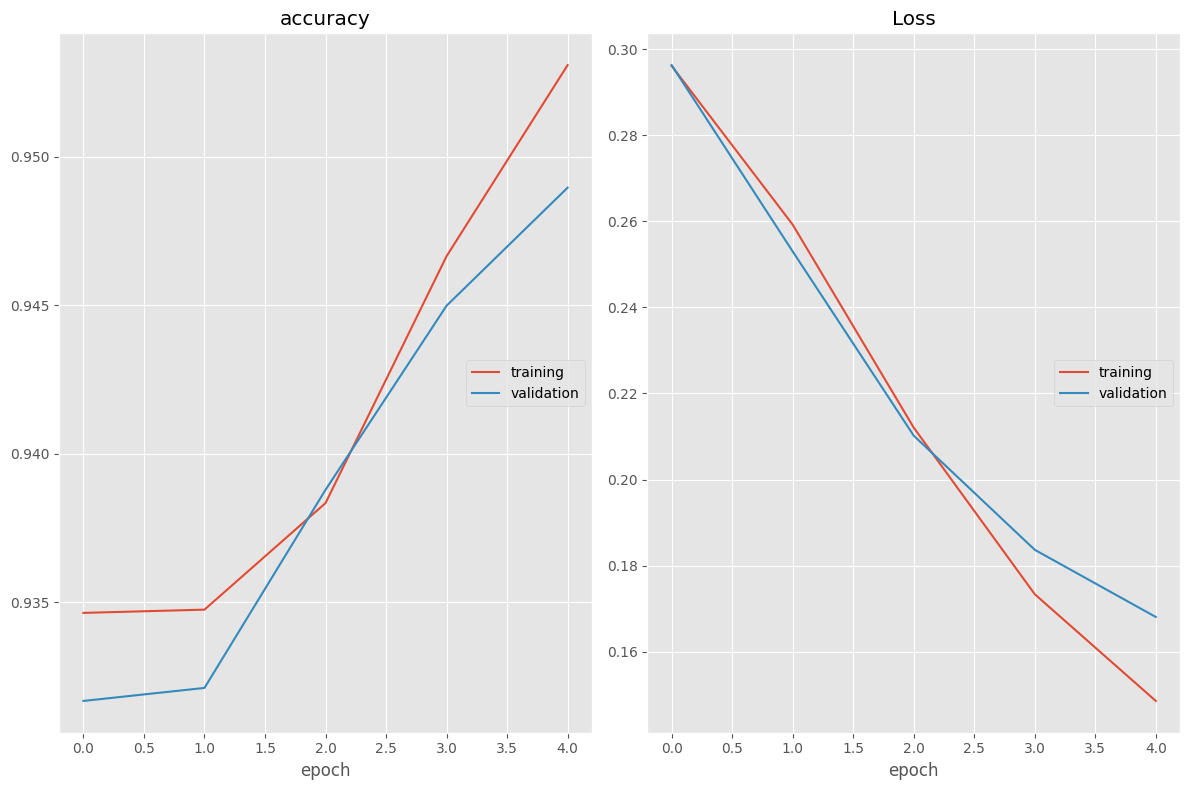

accuracy
	training         	 (min:    0.935, max:    0.953, cur:    0.953)
	validation       	 (min:    0.932, max:    0.949, cur:    0.949)
Loss
	training         	 (min:    0.149, max:    0.296, cur:    0.149)
	validation       	 (min:    0.168, max:    0.296, cur:    0.168)
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9534 - loss: 0.1474 - val_accuracy: 0.9490 - val_loss: 0.1680


In [83]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

#### **Evaluate Named Entity Recognition Model**

In [61]:
model.evaluate(x_test, np.array(y_test))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9486 - loss: 0.1733


[0.16691754758358002, 0.9500605463981628]

In [62]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Word           True 	 Pred

------------------------------
In             O    	O
a              O    	O
broadcast      O    	O
address        O    	O
to             O    	O
the            O    	O
nation         O    	O
Thursday       B-tim	B-geo
,              O    	O
General        B-per	B-per
Musharraf      I-per	I-per
promised       O    	O
"              O    	O
stern          O    	O
action         O    	O
"              O    	O
against        O    	O
those          O    	O
involved       O    	O
in             O    	O
the            O    	O
printing       O    	O
,              O    	O
publication    O    	O
and            O    	O
distribution   O    	O
of             O    	O
hate           O    	O
material       O    	O
,              O    	O
including      O    	O
newspapers     O    	O
,              O    	O
magazines      O    	O
,              O    	O
pamphlets      O    	O
,              O    	O
and            O    	O
audio          O   

### Conclusion

The LSTM model achieved an impressive accuracy of **95%** in identifying named entities. This result underscores the model's strong capability in understanding and classifying contextual information effectively. Future enhancements could include experimenting with more sophisticated architectures or incorporating additional features to further boost performance.
